In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch 

device = torch.device('cuda')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(
    image_size=256, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Running on device: cuda


In [3]:
import clip.clip as clip 

CLIP_MODEL,  clip_img_processor =clip.load('ViT-B/32', jit=False)

In [4]:
from src.data_loader import read_data

train_data = read_data('train')
val_data = read_data('val')
test_data = read_data('test')

100%|██████████| 200/200 [00:00<00:00, 5846.37it/s]


In [7]:
from src.config import BATCH_SIZE
import random 
import numpy as np 
import torch 

from src.networks.face_model import face_model_dataset

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

def get_dataloader(data):
    dataset = face_model_dataset(data, clip_img_processor, mtcnn, resnet)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True, worker_init_fn=seed_worker, generator=g)
    return data_loader
    
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)
test_loader = get_dataloader(test_data)

CLIP preprocessing: 100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


In [8]:
del resnet 
del mtcnn

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2/2 [00:01<00:00,  1.23it/s]




For epoch = 0
Training Loss = 0.5866684480146929 | Training Accuracy = 0.013162878787878786
Validation Loss = 0.5067921876907349|Validation Accuracy = 0.07963709677419355




100%|██████████| 2/2 [00:01<00:00,  1.22it/s]




For epoch = 1
Training Loss = 0.3993844281543385 | Training Accuracy = 0.13816287878787878
Validation Loss = 0.41023413836956024|Validation Accuracy = 0.09425403225806452




100%|██████████| 2/2 [00:01<00:00,  1.21it/s]




For epoch = 2
Training Loss = 0.29278007623824204 | Training Accuracy = 0.16392045454545456
Validation Loss = 0.3746422529220581|Validation Accuracy = 0.15977822580645162




100%|██████████| 2/2 [00:01<00:00,  1.20it/s]




For epoch = 3
Training Loss = 0.2563862116499381 | Training Accuracy = 0.20227272727272727
Validation Loss = 0.33293794095516205|Validation Accuracy = 0.11139112903225806




100%|██████████| 2/2 [00:01<00:00,  1.17it/s]




For epoch = 4
Training Loss = 0.25543919137933035 | Training Accuracy = 0.21505681818181818
Validation Loss = 0.30060677230358124|Validation Accuracy = 0.12752016129032256




100%|██████████| 2/2 [00:01<00:00,  1.14it/s]




For epoch = 5
Training Loss = 0.2660770050503991 | Training Accuracy = 0.22111742424242423
Validation Loss = 0.27985723316669464|Validation Accuracy = 0.12752016129032256




100%|██████████| 2/2 [00:01<00:00,  1.13it/s]




For epoch = 6
Training Loss = 0.2817372408780185 | Training Accuracy = 0.2296401515151515
Validation Loss = 0.2796763628721237|Validation Accuracy = 0.12651209677419356




100%|██████████| 2/2 [00:01<00:00,  1.12it/s]




For epoch = 7
Training Loss = 0.29512892392548645 | Training Accuracy = 0.22869318181818182
Validation Loss = 0.2896263152360916|Validation Accuracy = 0.12701612903225806




100%|██████████| 2/2 [00:01<00:00,  1.10it/s]




For epoch = 8
Training Loss = 0.30387459424408997 | Training Accuracy = 0.2475378787878788
Validation Loss = 0.29870685935020447|Validation Accuracy = 0.14264112903225806




100%|██████████| 2/2 [00:01<00:00,  1.11it/s]




For epoch = 9
Training Loss = 0.3058247484944083 | Training Accuracy = 0.2553977272727273
Validation Loss = 0.2962287366390228|Validation Accuracy = 0.1436491935483871




100%|██████████| 2/2 [00:01<00:00,  1.08it/s]




For epoch = 10
Training Loss = 0.29847695407542313 | Training Accuracy = 0.24166666666666667
Validation Loss = 0.2939777076244354|Validation Accuracy = 0.12701612903225806




100%|██████████| 2/2 [00:01<00:00,  1.09it/s]




For epoch = 11
Training Loss = 0.302575329487974 | Training Accuracy = 0.23229166666666667
Validation Loss = 0.29778146743774414|Validation Accuracy = 0.10987903225806452




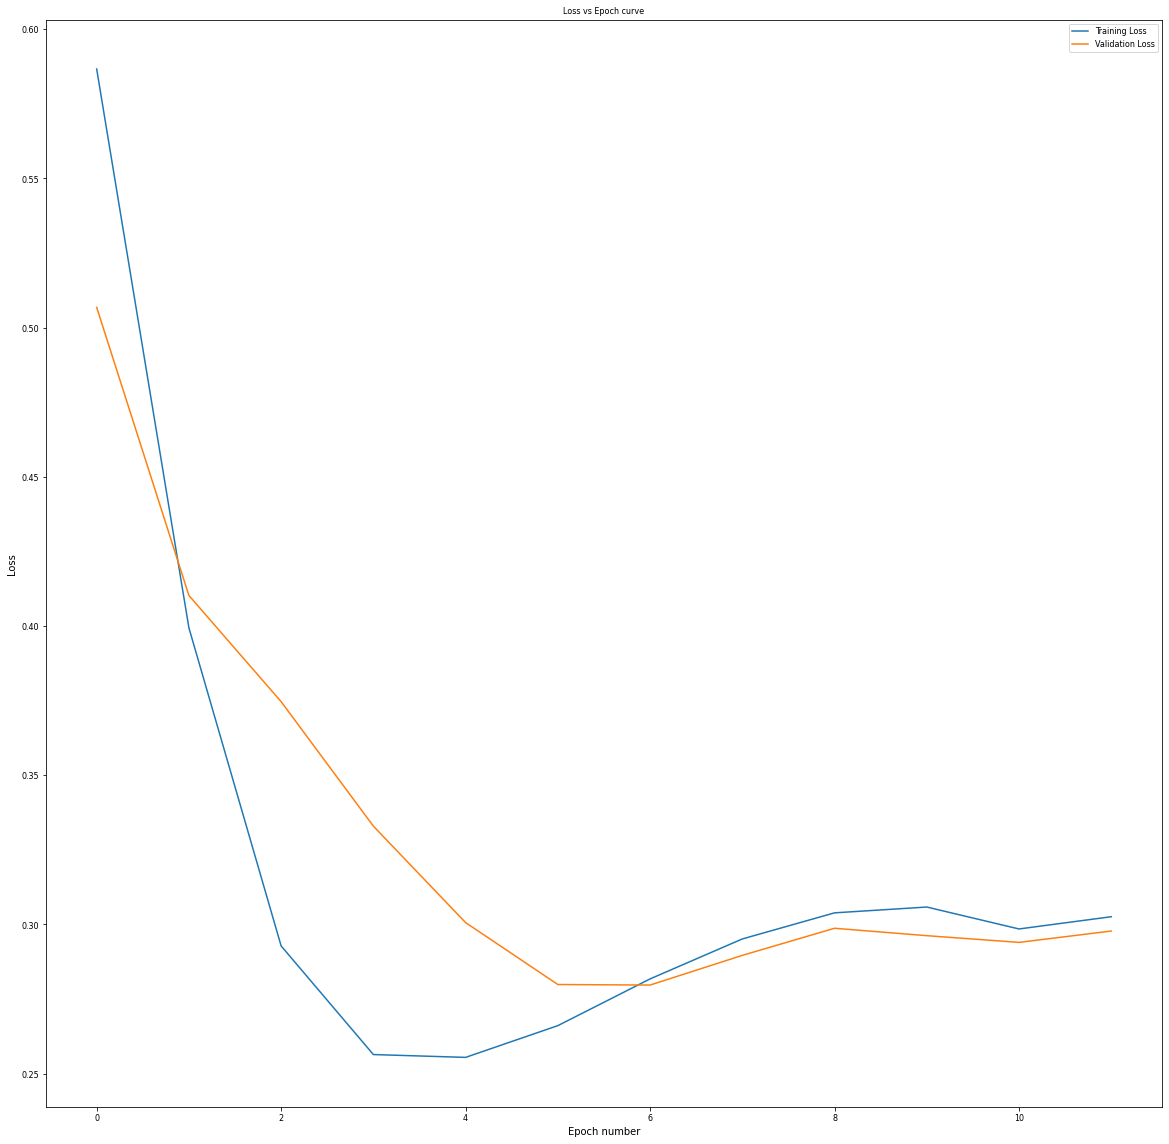

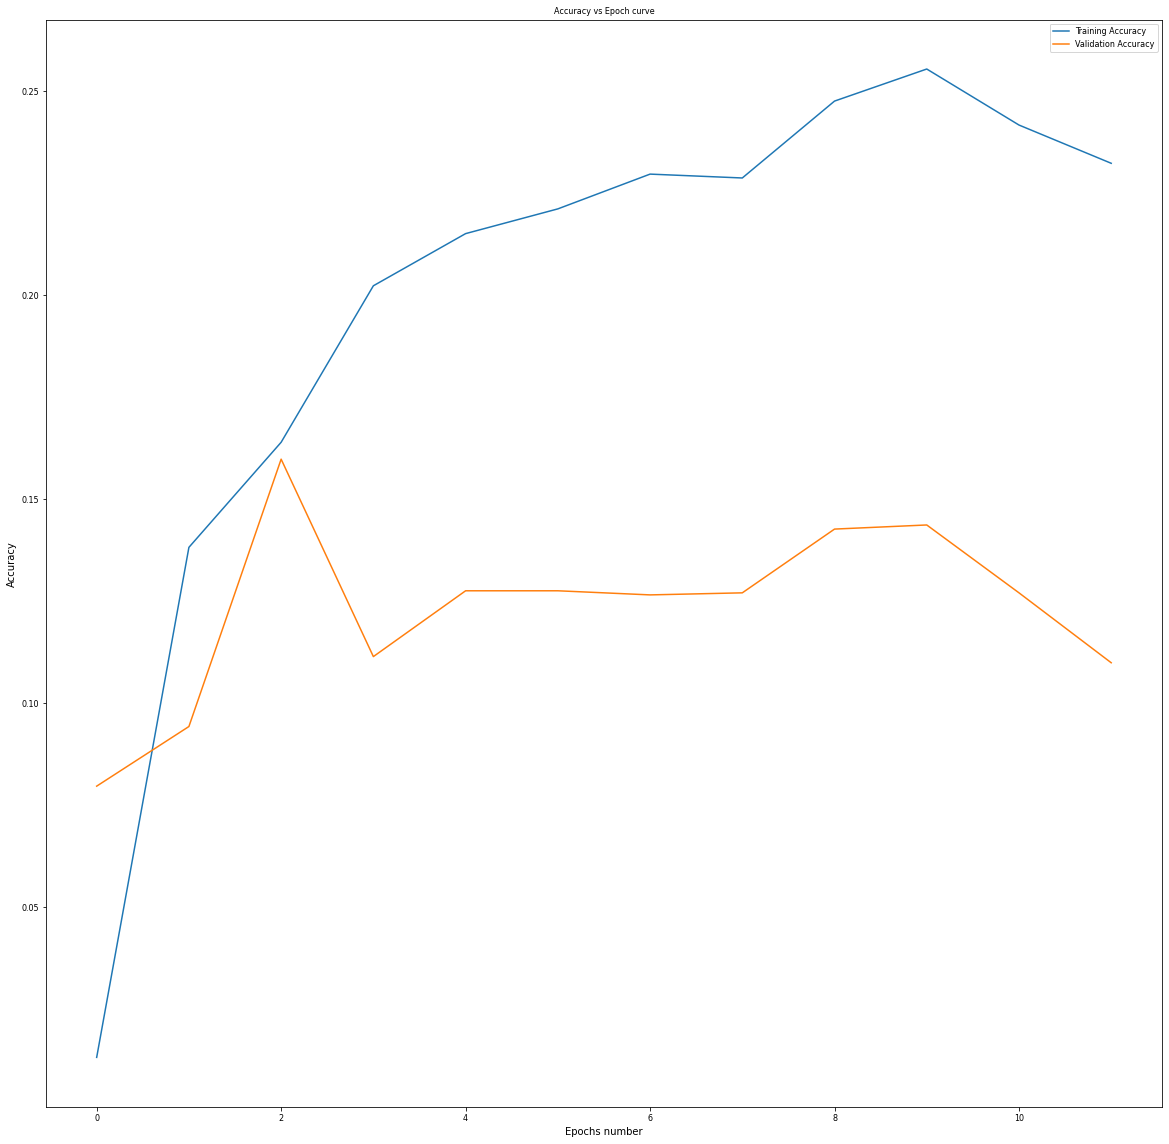

In [9]:
from src.trainer import Trainer
from src.networks.face_model import face_model_input_transformer, face_model
import torch.nn as nn
import torch 

trainer = Trainer(12)

#Set data
trainer.set_data(train_loader, val_loader)

#set model 
model = face_model(CLIP_MODEL).cuda()
input_transformer = face_model_input_transformer()
trainer.set_model(model, input_transformer)

#Backpropagation
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
trainer.set_optimizer(optimizer, loss_fn)
trainer.train(l2_r=1e-3)
trainer.plot()

In [ ]:
trainer.test(test_loader)

In [ ]:
torch.save(model.state_dict(), f"Models/clip_bert_face.model")
